# Energy Surface

> Plot potential energy surfaces and calculate freqencies for symmetric triatomics 

In [ ]:
#| default_exp optimisation

In [ ]:
#| export
#| echo: false
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
#| hide
import os

In [ ]:
#| echo: false
h2opath = ('../Ex2/H2Ooutfiles')
h2spath = ('../Ex2/H2Soutfiles')

In [ ]:
#| hide
basepath = os.getcwd()
print(os.getcwd())
os.chdir(h2opath)
print(os.getcwd())
os.chdir(basepath )

c:\Users\kirpa\OneDrive\Documents\ChemIITools\nbs
c:\Users\kirpa\OneDrive\Documents\ChemIITools\Ex2\H2Ooutfiles


In [ ]:
#| export
def parse_out(file):
    """
    parses an out file of a symmetric triatomic for the bond length, angle and SCF energy
    """
    shape_lookup = "Symbolic Z-matrix"
    energy_lookup = "SCF Done"
    e_search = r'(?<=SCF Done:  E\(RHF\) =).+?(?=A\.U\.)'
    r_search = r'(?<=1).+?(?= 2 )'
    a_search = r'(?<= 2 ).*'
    shape_line = None
    with open(file) as myFile:
        for num, line in enumerate(myFile):
            if shape_lookup in line:
                shape_line = num+4
            if num == shape_line:
                r= float(re.findall(r_search,line)[0])
                angle= float(re.findall(a_search,line)[0])
            if energy_lookup in line:
                energy= float(re.findall(e_search,line)[0])
    return ((r, angle), energy)

In [ ]:
h2o_vals = {}
for filename in os.listdir(h2opath):
    output = parse_out(os.path.join(h2opath, filename))
    h2o_vals[output[0]] = output[1]

In [ ]:
#| echo: false
h2s_vals = {}
for filename in os.listdir(h2spath):
    output = parse_out(os.path.join(h2spath, filename))
    h2s_vals[output[0]] = output[1]

In [ ]:
#| export
def _func(r,theta, dict):
    # dictionary lookup
    return dict[(r,theta)]
def _dict_to_mesh(dict):
    """
    convert a dictioonary of ((r,theta) z) values to a mesh
    """
    r,theta = zip(*dict.keys())
    r = np.unique(r)
    theta = np.unique(theta)
    r,theta= np.meshgrid(r,theta)
    z = np.array([_func(r,theta, dict) for (r,theta) in zip(r.ravel(), theta.ravel())]).reshape(r.shape)




    return r,theta, z

In [ ]:
#| export
def surface_plot(dict, fname = None):
    """Plots a surface from the output of the regex"""
    r,theta, z = _dict_to_mesh(dict)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(r,theta, z, cmap=cm.plasma, linewidth=0)
    plt.xlabel('Bond Length / $\AA$')
    plt.ylabel('Bond Angle / $^\circ$')
    ax.set_zlabel('\nEnergy / $E_{h}$', linespacing=2.8)
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname)
    plt.show()

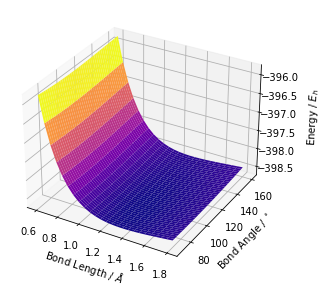

In [ ]:
surface_plot(h2s_vals)

In [ ]:
#| export
def heatmap(dict, fname = None):
    """Plots a heatmap from the output of the regex"""
    r,theta, z = _dict_to_mesh(dict)
    z_min, z_max = z.min(), z.max()
    fig, ax = plt.subplots()

    c = ax.pcolormesh(r,theta, z, cmap=cm.plasma, vmin=z_min, vmax=z_max)
    # set the limits of the plot to the limits of the data
    ax.axis([r.min(), r.max(), theta.min(), theta.max()])
    fig.colorbar(c, ax=ax)
    plt.xlabel('Bond Length / $\AA$')
    plt.ylabel('Bond Angle / $^\circ$')
    if fname is not None:
        plt.savefig(fname)
    plt.show()

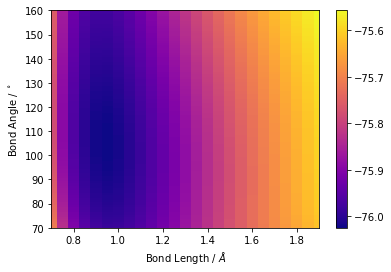

In [ ]:
heatmap(h2o_vals)

In [ ]:
#| export
def vib_calc(dict, mass = 1.6735575E-27, plot = False):
    """
    Calculate optimum bond length and angle and symmetric stretch and bending frequencies.
    Default mass is that of the hydrogen atom
    """
    h_to_J = 4.3597482E-18 # hartree to joule conversion factor
    deg_to_r = np.pi/180 # degrees to radians
    A_to_m = 1E-10 # angstrom to m
    Hz_to_rcm = 1/29979245800 # Hertz to wavenumbers in cm-1
    r_opt, theta_opt = min(dict, key=dict.get)
    r,theta = zip(*dict.keys())
    r = np.unique(r)
    theta = np.unique(theta)
    zr = [] # with constant theta
    ztheta = [] # with constant r

    for length in r:
        zr.append(dict[(length, theta_opt)]*h_to_J)

    zr = np.array(zr)
    r_adj = (r - r_opt)*A_to_m
    rslice = (r_adj>=.25*r_adj.min()) & (r_adj<=.25*r_adj.max()) # the quadratic is fitted on these points
    rfit = np.linspace(r_adj.min(), r_adj.max(), 1000)
    rquad = np.linspace(.4*r_adj.min(), .4*r_adj.max(), 1000)

    poly = np.polyfit(r_adj , zr, 8)
    quad = np.polyfit(r_adj [rslice], zr[rslice], 2)
    zfit = np.polyval(poly, rfit)
    zquad = np.polyval(quad, rquad)
    if plot:
        plt.plot(r_adj, zr,"ro")
        plt.plot(rfit, zfit)
        plt.plot(rquad, zquad)
        plt.xlabel('Bond Length from Optimum/ m')
        plt.ylabel('Energy/ J')
        plt.show()

    kr = 2*quad[0]
    mu_1 = 2*mass
    nu_r = np.sqrt(kr/mu_1)/(2*np.pi)

    for angle in theta:
        ztheta.append(dict[(r_opt, angle)]*h_to_J)

    ztheta = np.array(ztheta)
    theta_adj = (theta-theta_opt)*deg_to_r
    thetaslice = (theta_adj>=.25*theta_adj.min()) & (theta_adj<=.25*theta_adj.max()) # the quadratic is fitted on these points

    thetafit = np.linspace(theta_adj.min(), theta_adj.max(), 1000)
    thetaquad = np.linspace(.4*theta_adj.min(), .4*theta_adj.max(), 1000)
    poly = np.polyfit(theta_adj , ztheta, 8)
    quad = np.polyfit(theta_adj[thetaslice], ztheta[thetaslice], 2)
    zfit = np.polyval(poly, thetafit)
    zquad = np.polyval(quad, thetaquad)

    if plot:
        plt.plot(theta_adj, ztheta,"ro", markersize=2)
        plt.plot(thetafit, zfit)
        plt.plot(thetaquad, zquad)
        plt.xlabel('Bond Angle from Optimum/ rad')
        plt.ylabel('Energy/ J')
        plt.show()

    ktheta = 2*quad[0]
    mu_2 = 0.5*mass
    nu_theta = np.sqrt(ktheta/(mu_2*(r_opt*A_to_m)**2))/(2*np.pi)

    return r_opt, theta_opt, nu_r*Hz_to_rcm, nu_theta*Hz_to_rcm

Assuming around the equilibrium point, the relevant part of each polynomial is the quadratic, for the stretching frequency: $$E=E_{0}+\frac{1}{2}k_{r}(r-\bar{r})^{2}+\frac{1}{2}k_{\theta}(\theta-\bar{\theta})^{2}$$ and thus $$F = -\nabla E=\begin{pmatrix}-k_{r}r\\-k_{\theta}\theta \end{pmatrix}$$ and so $\nu_{r} = \frac{1}{2\pi}\sqrt{\frac{k_{r}}{\mu_{1}}}$ and $\nu_{\theta} = \frac{1}{2\pi}\sqrt{\frac{k_{\theta}}{r^{2}\mu_{2}}}$, where $\mu_{1}\approx 2 m_{u}$ and $\mu_{2}\approx 0.5 m_{u}$. For both water and hydrogen disulfide $m_{u}$ is the mass of the hydrogen atom

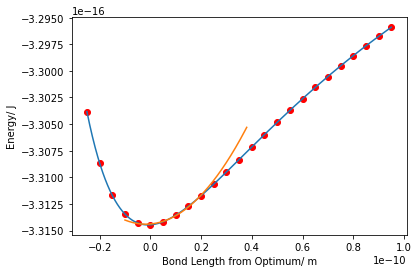

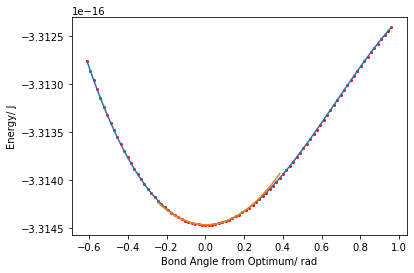

the optimum bond length of water is  0.95  angstroms with angle  105.0  degrees
the stretching frequency  3113  cm-1 and bending frequency  1665  cm-1


In [ ]:
r_opt, theta_opt, nu_r, nu_theta = vib_calc(h2o_vals, plot= True)
print('the optimum bond length of water is ', r_opt, ' angstroms with angle ', theta_opt, ' degrees' )
print('the stretching frequency ', round(nu_r), ' cm-1 and bending frequency ', round(nu_theta), ' cm-1' )

Similarly for hydrogen sulfide

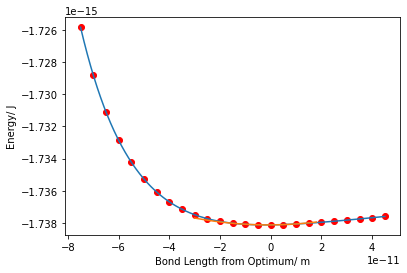

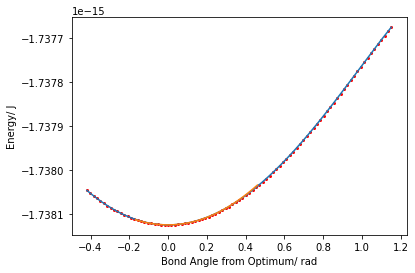

the optimum bond length of hydrogen sulfide is  1.35  angstroms with angle  94.0  degrees
the stretching frequency  2922  cm-1 and bending frequency  1255  cm-1


In [ ]:
r_opt, theta_opt, nu_r, nu_theta = vib_calc(h2s_vals, plot= True)
print('the optimum bond length of hydrogen sulfide is ', r_opt, ' angstroms with angle ', theta_opt, ' degrees' )
print('the stretching frequency ', round(nu_r), ' cm-1 and bending frequency ', round(nu_theta), ' cm-1' )

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()